In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import datetime, warnings, scipy 

In [89]:
path = '/home/jewelle/data_bootcamp/'
flights_df =  pd.read_csv(path +'flights_sub.csv', parse_dates=['fl_date'])
flights_df.head()

,Unnamed: 0,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,0,2018-01-23,UA,UA_CODESHARE,UA,3405,YX,N653RW,3405,10821,...,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2018-11-15,AA,AA_CODESHARE,AA,5683,OH,N594NN,5683,11057,...,640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-10-29,WN,WN,WN,2434,WN,N432WN,2434,12889,...,867.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-11-14,B6,B6,B6,577,B6,N968JT,577,11697,...,2584.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-05-22,DL,DL_CODESHARE,DL,3762,OO,N8933B,3762,10397,...,508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
dt_col = ['crs_dep_time', 'dep_time', 'crs_arr_time', 'arr_time', 'wheels_off', 'wheels_on']

In [91]:
def convert_time(x):
    if np.isnan(x):
        return '00:00'
    
    if x == 2400:
        return '23:59'   
    string = str(int(x))
    
    if len(string)< 4:
        for _ in range(4-len(string)):
            string = '0' + string
    
    return string[:2] + ':' + string[2:]

In [92]:
#run convert_time
flights_df['crs_dep_time'] = flights_df['crs_dep_time'].apply(lambda x: convert_time(x))
flights_df['crs_dep_time'] = pd.to_datetime(flights_df['crs_dep_time'], format = '%H:%M')

flights_df['dep_time'] = flights_df['dep_time'].apply(lambda x: convert_time(x))
flights_df['dep_time'] = pd.to_datetime(flights_df['dep_time'], format = '%H:%M')
flights_df['dep_hour'] = flights_df['dep_time'].dt.hour

flights_df['crs_arr_time'] = flights_df['crs_arr_time'].apply(lambda x: convert_time(x))
flights_df['crs_arr_time'] = pd.to_datetime(flights_df['crs_arr_time'], format = '%H:%M')

flights_df['arr_time'] = flights_df['arr_time'].apply(lambda x: convert_time(x))
flights_df['arr_time'] = pd.to_datetime(flights_df['arr_time'], format = '%H:%M')
flights_df['arr_hour'] = flights_df['arr_time'].dt.hour

flights_df['wheels_off'] = flights_df['wheels_off'].apply(lambda x: convert_time(x))
flights_df['wheels_off'] = pd.to_datetime(flights_df['wheels_off'], format = '%H:%M')

flights_df['wheels_on'] = flights_df['wheels_on'].apply(lambda x: convert_time(x))
flights_df['wheels_on'] = pd.to_datetime(flights_df['wheels_on'], format = '%H:%M')

In [93]:
flights_df.drop(['Unnamed: 0', 'mkt_unique_carrier', 'dup', 'no_name'], axis=1, inplace=True)

In [99]:
#check for missing values
total = flights_df.isnull().sum().sort_values(ascending=False)
percent = (flights_df.isnull().sum()/flights_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
arr_hour,0,0.0
wheels_off,0,0.0
dep_delay,0,0.0
dep_time,0,0.0
crs_dep_time,0,0.0


In [95]:
#drop columns with >82% missing data
drop_columns = missing_data[missing_data['Percent'] > 0.82].index.tolist()
flights_df.drop(drop_columns, axis=1, inplace=True)

In [96]:
flights_df.dropna(subset=['air_time', 'actual_elapsed_time', 'taxi_in', 'taxi_out'], inplace=True)

In [97]:
float_cols = flights_df.columns[flights_df.dtypes=='float64']
flights_df[float_cols] = flights_df[float_cols].fillna('0.0')
flights_df.fillna(0,inplace=True)

In [98]:
flights_df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
            'late_aircraft_delay', 'arr_delay', 'dep_delay']] = flights_df[['carrier_delay', 'weather_delay', 
                                                                            'nas_delay', 'security_delay', 
                                                                            'late_aircraft_delay', 'arr_delay', 
                                                                            'dep_delay']].apply(pd.to_numeric)

In [107]:
flights_df.head()

,fl_date,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,...,nas_delay,security_delay,late_aircraft_delay,dep_hour,arr_hour,delayed,haul,month,season,dep_time_of_the_day
0,2018-01-23,UA_CODESHARE,UA,3405,YX,N653RW,3405,10821,BWI,"Baltimore, MD",...,0.0,0.0,0.0,5,7,0,SHORT,1,winter,night
1,2018-11-15,AA_CODESHARE,AA,5683,OH,N594NN,5683,11057,CLT,"Charlotte, NC",...,0.0,0.0,0.0,9,10,0,SHORT,11,autumn,morning
2,2019-10-29,WN,WN,2434,WN,N432WN,2434,12889,LAS,"Las Vegas, NV",...,0.0,0.0,0.0,21,23,1,SHORT,10,autumn,evening
3,2019-11-14,B6,B6,577,B6,N968JT,577,11697,FLL,"Fort Lauderdale, FL",...,0.0,0.0,0.0,8,11,0,SHORT,11,autumn,morning
4,2019-05-22,DL_CODESHARE,DL,3762,OO,N8933B,3762,10397,ATL,"Atlanta, GA",...,0.0,0.0,0.0,14,15,0,SHORT,5,spring,afternoon


#### Feature Engineering

* weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
* statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
* airports encoding: we need to think about what to do with the airports and other categorical variables
* time of the day: the delay probably depends on the airport traffic which varies during the day.
* airport traffic
* unsupervised learning as feature engineering?

what are the additional options?: Think about what we could do more to improve the model.

In [122]:
flights_df['delayed'] = flights_df['arr_delay'].apply(lambda x: x > 0)
flights_df['delayed'] = flights_df['delayed'].astype(int)

In [102]:
def haul_distance(x):
    if x < 2600:
        return 'SHORT'
    elif x >= 2600 and x < 3000:
        return 'MEDIUM'
    elif x >= 3000:
        return 'LONG'

In [103]:
flights_df['haul'] = flights_df['distance'].apply(lambda x: haul_distance(x))

In [104]:
flights_df['month'] = flights_df['fl_date'].dt.month

In [105]:
flights_df["season"] = "winter"
flights_df.loc[flights_df["month"].between(3,5), "season"] = "spring"
flights_df.loc[flights_df["month"].between(6,8), "season"] = "summer"
flights_df.loc[flights_df["month"].between(9,11), "season"] = "autumn"

In [106]:
flights_df["dep_time_of_the_day"] = "night"
flights_df.loc[flights_df["dep_hour"].between(6,11), "dep_time_of_the_day"] = "morning"
flights_df.loc[flights_df["dep_hour"].between(12,17), "dep_time_of_the_day"] = "afternoon"
flights_df.loc[flights_df["dep_hour"].between(18,21), "dep_time_of_the_day"] = "evening"

In [108]:
flights_df.select_dtypes(include=['object'])

,branded_code_share,mkt_carrier,op_unique_carrier,tail_num,origin,origin_city_name,dest,dest_city_name,haul,season,dep_time_of_the_day
0,UA_CODESHARE,UA,YX,N653RW,BWI,"Baltimore, MD",EWR,"Newark, NJ",SHORT,winter,night
1,AA_CODESHARE,AA,OH,N594NN,CLT,"Charlotte, NC",LIT,"Little Rock, AR",SHORT,autumn,morning
2,WN,WN,WN,N432WN,LAS,"Las Vegas, NV",SEA,"Seattle, WA",SHORT,autumn,evening
3,B6,B6,B6,N968JT,FLL,"Fort Lauderdale, FL",SFO,"San Francisco, CA",SHORT,autumn,morning
4,DL_CODESHARE,DL,OO,N8933B,ATL,"Atlanta, GA",FWA,"Fort Wayne, IN",SHORT,spring,afternoon
...,...,...,...,...,...,...,...,...,...,...,...
9994,DL_CODESHARE,DL,G7,N376CA,PIT,"Pittsburgh, PA",DTW,"Detroit, MI",SHORT,winter,evening
9995,WN,WN,WN,N789SW,DEN,"Denver, CO",OAK,"Oakland, CA",SHORT,spring,afternoon
9996,WN,WN,WN,N903WN,SNA,"Santa Ana, CA",LAS,"Las Vegas, NV",SHORT,spring,afternoon
9998,DL_CODESHARE,DL,9E,N935XJ,LGA,"New York, NY",CLT,"Charlotte, NC",SHORT,summer,afternoon


In [112]:
#One Hot Encoding for categorical variables is going make the dataset too unwieldy
#Try label encoding?
lb_make = LabelEncoder()
flights_df["dest_code"] = lb_make.fit_transform(flights_df["dest"])
flights_df[["dest", "dest_code"]].head()


,dest,dest_code
0,EWR,97
1,LIT,171
2,SEA,272
3,SFO,274
4,FWA,110


In [113]:
#label encoding for other categoricals

In [ ]:
#save to csv

#### Regression
The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights 1 week in advance.

In [117]:
delays = flights_df[['mkt_carrier', 'arr_delay', 'dep_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
            'late_aircraft_delay', 'month']]
delays.head()

,mkt_carrier,arr_delay,dep_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,month
0,UA,-2.0,-16.0,0.0,0.0,0.0,0.0,0.0,1
1,AA,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2,WN,9.0,8.0,0.0,0.0,0.0,0.0,0.0,10
3,B6,-23.0,-9.0,0.0,0.0,0.0,0.0,0.0,11
4,DL,-1.0,16.0,0.0,0.0,0.0,0.0,0.0,5


In [118]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [125]:
stats_dep_delay = flights_df['dep_delay'].groupby(flights_df['mkt_carrier']).apply(get_stats).unstack()
stats_dep_delay = stats_dep_delay.sort_values('count')
stats_dep_delay

,min,max,count,mean
mkt_carrier,,,,
VX,-12.0,28.0,11.0,2.636364
HA,-15.0,46.0,105.0,-1.552381
G4,-25.0,125.0,138.0,4.101449
F9,-15.0,434.0,166.0,22.120482
NK,-18.0,995.0,242.0,15.607438
B6,-18.0,803.0,377.0,21.228117
AS,-24.0,223.0,525.0,2.817143
WN,-14.0,302.0,1687.0,10.710136
UA,-22.0,1023.0,1876.0,15.539979


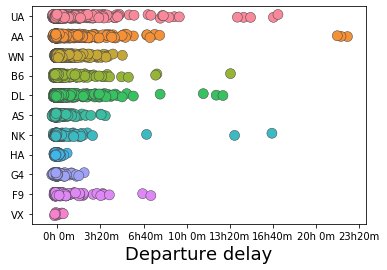

In [134]:
ax3 = sns.stripplot(y="mkt_carrier", x="dep_delay", size=10, data=flights_df, linewidth = 0.5)
plt.setp(ax3.get_xticklabels(), fontsize=10)
plt.setp(ax3.get_yticklabels(), fontsize=10)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18)
ax3.yaxis.label.set_visible(False)

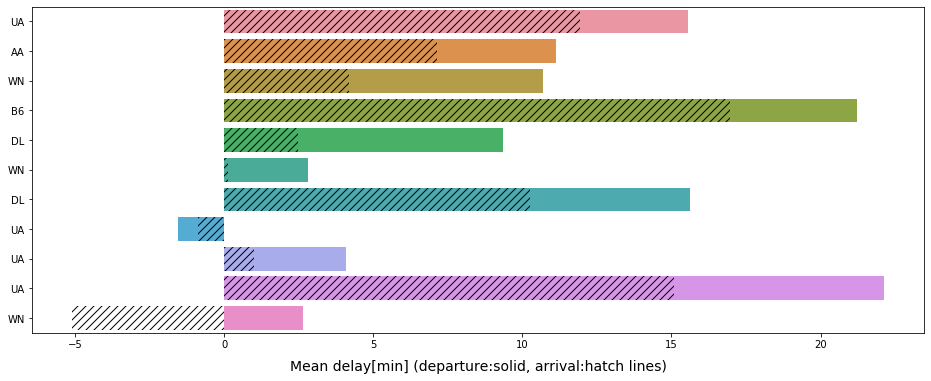

In [142]:
fig = plt.figure(1, figsize=(16,6))
ax = sns.barplot(x="dep_delay", y="mkt_carrier", data=flights_df, ci=None)
ax = sns.barplot(x="arr_delay", y="mkt_carrier", data=flights_df, color="r", hatch = '///', alpha = 0.0, ci=None)

ax.set_yticklabels(flights_df['mkt_carrier'])
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay[min] (departure:solid, arrival:hatch lines)',
           fontsize=14, labelpad=10);

AttributeError: 'Index' object has no attribute 'remove_unused_levels'